In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import poisson, binom, nbinom, lognorm, gamma
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

### DATA IMPORTATION

In [107]:
data = pd.read_csv('claim_data_group3_2024.csv')
# make IDpol the index
data.set_index('IDpol', inplace=True)
data

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1093259.0,0.0,1.00,C,6.0,2.0,76.0,62.0,B12,Regular,306.0,R82,0.0
5026741.0,0.0,0.54,F,5.0,3.0,56.0,50.0,B12,Diesel,27000.0,R11,0.0
1081095.0,0.0,0.25,C,7.0,3.0,36.0,50.0,B5,Diesel,222.0,R24,0.0
3062789.0,0.0,1.00,C,6.0,4.0,58.0,69.0,B1,Regular,229.0,R53,0.0
4114350.0,0.0,1.00,A,4.0,14.0,67.0,50.0,B2,Regular,10.0,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6069891.0,0.0,0.52,A,4.0,1.0,63.0,95.0,B12,Regular,42.0,R74,0.0
6009212.0,0.0,0.70,E,10.0,5.0,65.0,52.0,B12,Regular,4348.0,R72,0.0
4013191.0,0.0,0.36,D,6.0,3.0,51.0,50.0,B12,Diesel,1955.0,R94,0.0


### DATA VISUALIZATION

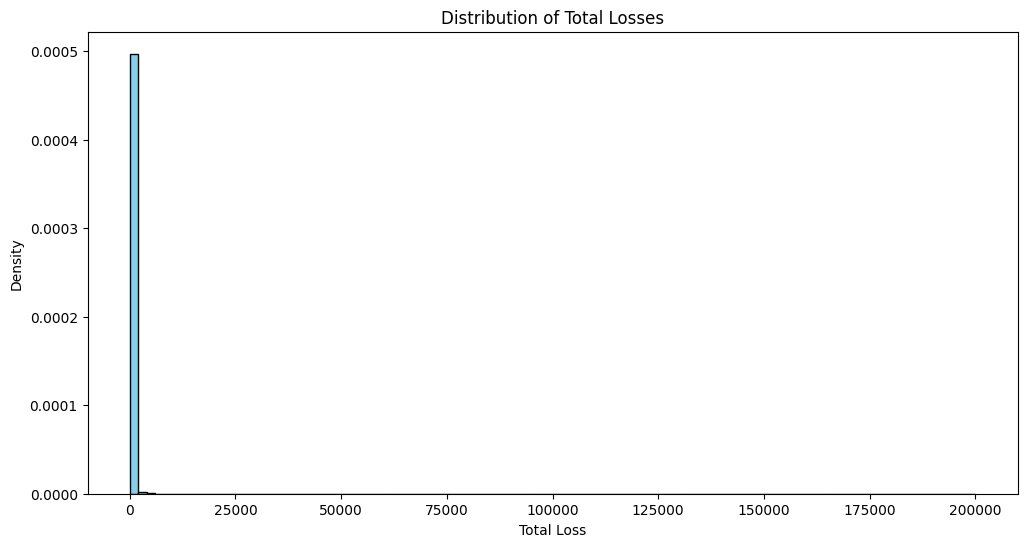

In [108]:
# plot the distribution of the claim amount
plt.figure(figsize=(12, 6))
plt.hist(data["ClaimAmount"], bins=100, color='skyblue', edgecolor='black', density=True)
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Distribution of Total Losses')
plt.show()


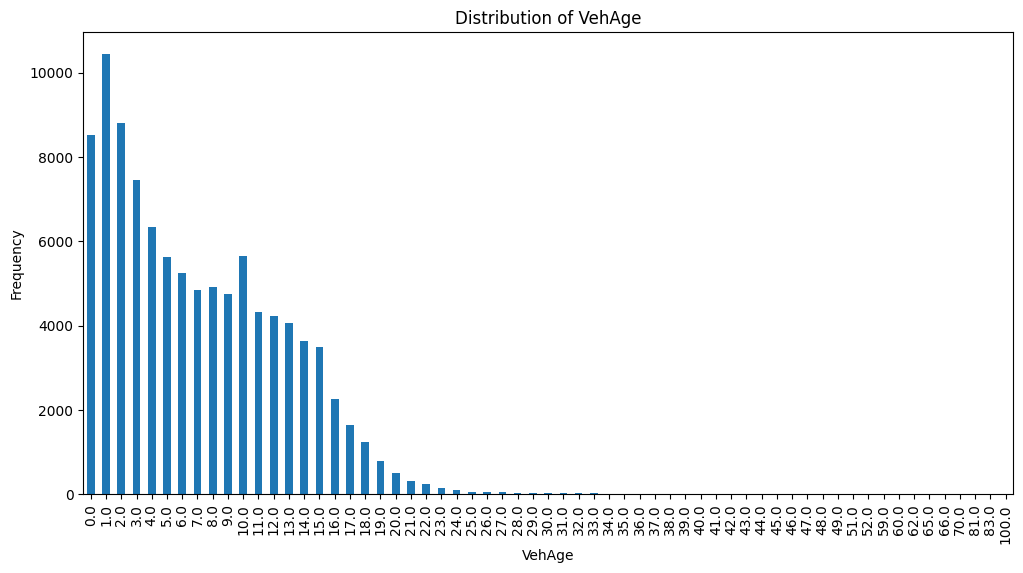

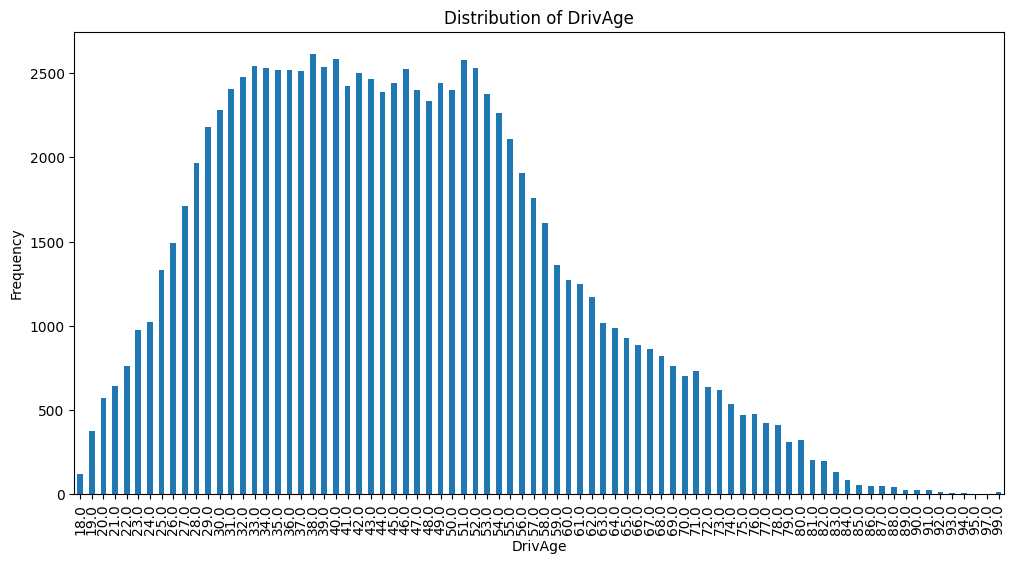

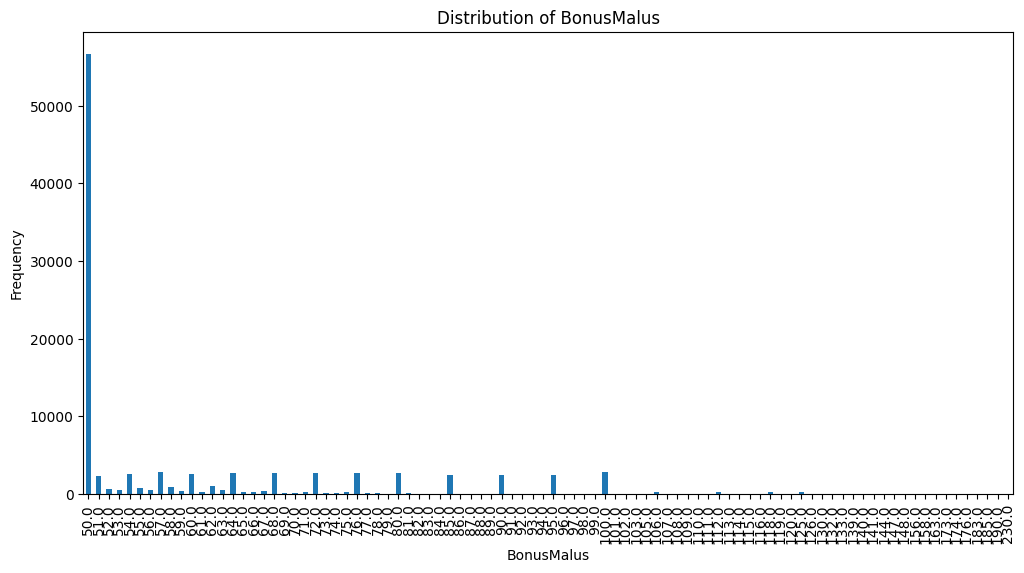

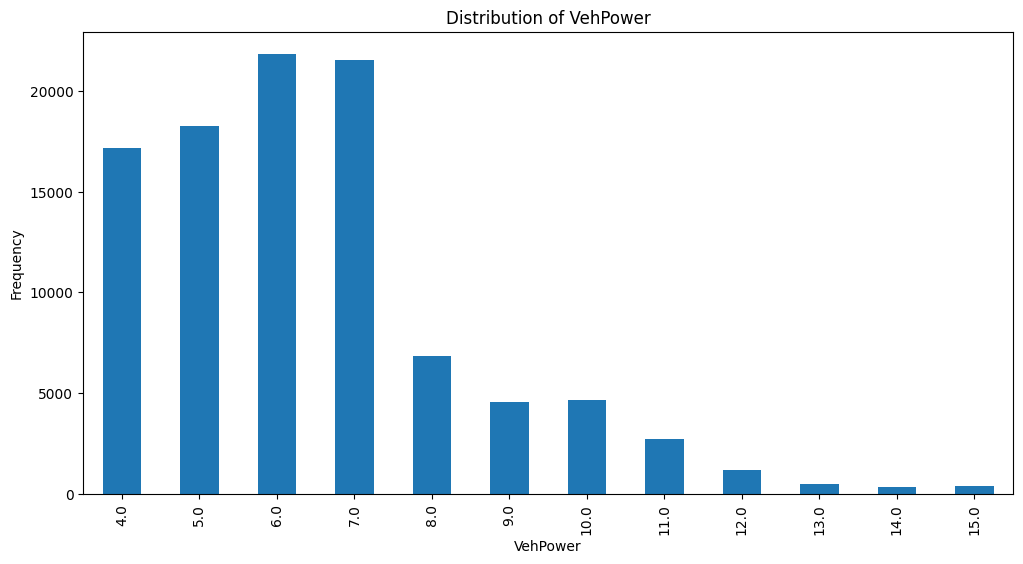

In [109]:
vars = ['VehAge', 'DrivAge', 'BonusMalus','VehPower']
for var in vars:
    data.groupby(var).size().plot(kind='bar', figsize=(12, 6))
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title('Distribution of ' + var)
    plt.show()


### TRAIN and VALIDATION SETS

In [110]:
train_data, valid_data = train_test_split(data, test_size=0.3, random_state=42)

### RISK CLASSIFICATION ALGORITHM

### PREDICTING TOTAL LOSSES

#### FREQUENCY DISTRIBUTIONS

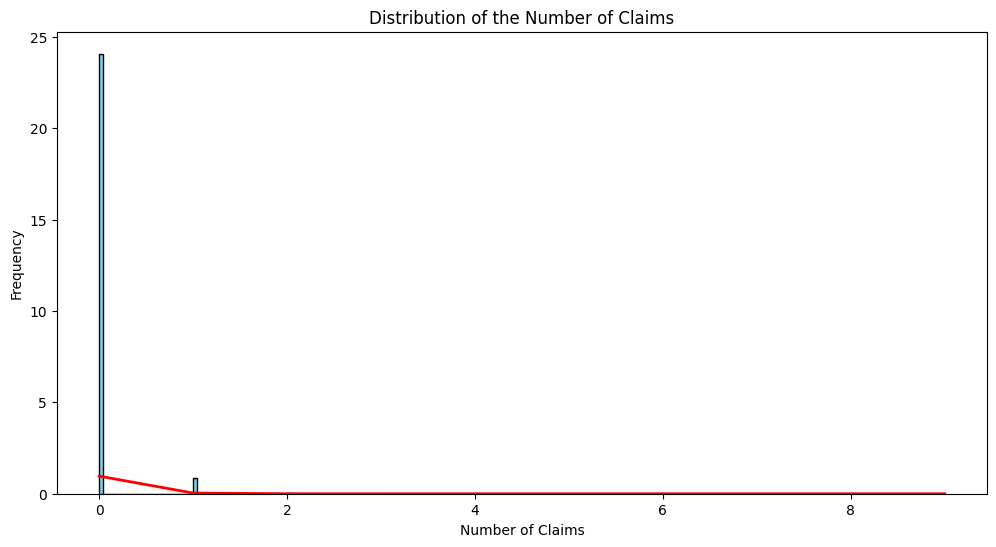

In [111]:
# Fit a Poisson distribution to the number of claims

lambda_poisson = train_data['ClaimNb'].mean()
poisson_dist = poisson(mu=lambda_poisson)

plt.figure(figsize=(12, 6))
plt.hist(train_data['ClaimNb'], bins=100, color='skyblue', edgecolor='black', density=True)
plt.xlabel('Number of Claims')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of Claims')
x = np.arange(0, 10)
plt.plot(x, poisson_dist.pmf(x), 'r-', lw=2)
plt.show()

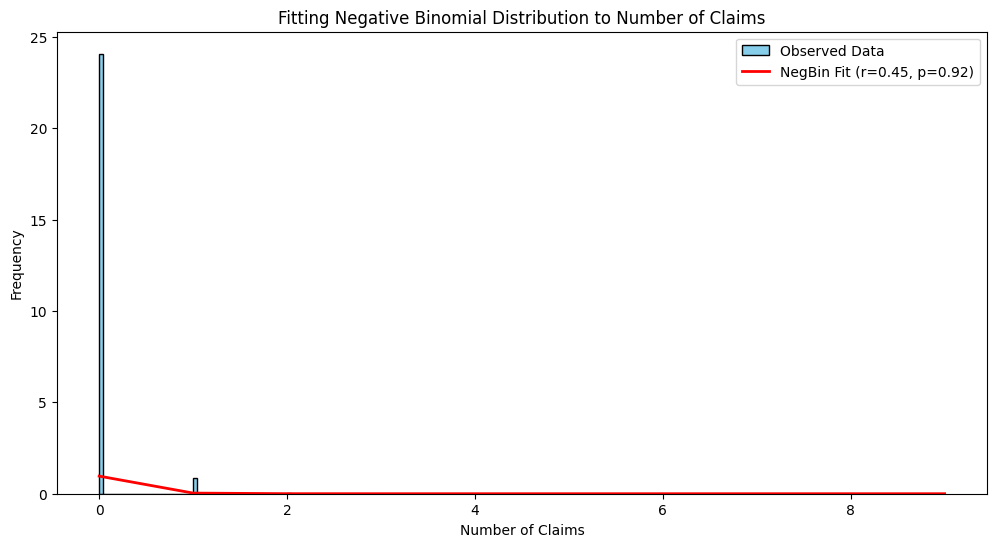

In [112]:
# Fit a Negative Binomial distribution to the number of claims

mean_claims = train_data['ClaimNb'].mean()
var_claims = train_data['ClaimNb'].var()

r = mean_claims**2 / (var_claims - mean_claims)
p = mean_claims / var_claims

neg_bin_dist = nbinom(n=r, p=p)

plt.figure(figsize=(12, 6))
plt.hist(train_data['ClaimNb'], bins=100, color='skyblue', edgecolor='black', density=True, label="Observed Data")
plt.xlabel('Number of Claims')
plt.ylabel('Frequency')
plt.title('Fitting Negative Binomial Distribution to Number of Claims')

x = np.arange(0, 10) 
plt.plot(x, neg_bin_dist.pmf(x), 'r-', lw=2, label=f'NegBin Fit (r={r:.2f}, p={p:.2f})')
plt.legend()
plt.show()


In [113]:
log_likelihood = poisson_dist.logpmf(train_data['ClaimNb']).sum()
print('Poisson log-likelihood:', log_likelihood)

Poisson log-likelihood: -11656.746493115279


In [114]:
log_likelihood = neg_bin_dist.logpmf(train_data['ClaimNb']).sum()
print('Negative Binomial log-likelihood:', log_likelihood)

Negative Binomial log-likelihood: -11583.618876457605


Poisson has a lower log-likelihood, meaning it has better goodness of fit to the training data than the NegBin distribution.

In [115]:
# Simulate claim frequency on the validation set using both models

poisson_forecasts = poisson.rvs(mu=lambda_poisson, size=len(valid_data))

negbin_forecasts = nbinom.rvs(n=r, p=p, size=len(valid_data))

actual_claims = valid_data['ClaimNb'].values

mse_poisson = mean_squared_error(actual_claims, poisson_forecasts)
mse_negbin = mean_squared_error(actual_claims, negbin_forecasts)

print('Poisson MSE:', mse_poisson)
print('Negative Binomial MSE:', mse_negbin)



Poisson MSE: 0.0832
Negative Binomial MSE: 0.0836


Poisson has a lower mean-squared error on the validation set, meaning it has better forecasting performance than NegBin for claim frequency. 

We therefore select Poisson as the distribution that has the best goodness-of fit and forecasting performance for claim frequency.

#### SEVERITY DISTRIBUTIONS

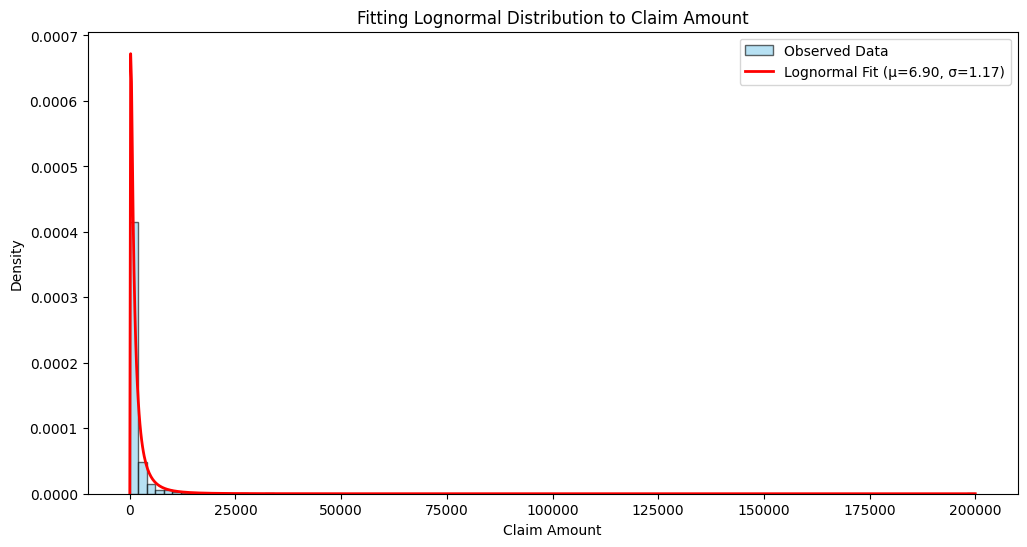

In [116]:
# Fit a lognormal distribution to the claim amount

positive_claims = train_data['ClaimAmount'][train_data['ClaimAmount'] > 0]

log_claims = np.log(positive_claims)
mu, sigma = np.mean(log_claims), np.std(log_claims)

shape = sigma  
loc = 0  
scale = np.exp(mu) 

lognorm_dist = lognorm(s=shape, loc=loc, scale=scale)

plt.figure(figsize=(12, 6))
plt.hist(positive_claims, bins=100, color='skyblue', edgecolor='black', density=True, alpha=0.6, label="Observed Data")
x = np.linspace(positive_claims.min(), positive_claims.max(), 1000)
plt.plot(x, lognorm_dist.pdf(x), 'r-', lw=2, label=f'Lognormal Fit (μ={mu:.2f}, σ={sigma:.2f})')
plt.xlabel('Claim Amount')
plt.ylabel('Density')
plt.title('Fitting Lognormal Distribution to Claim Amount')
plt.legend()
plt.show()

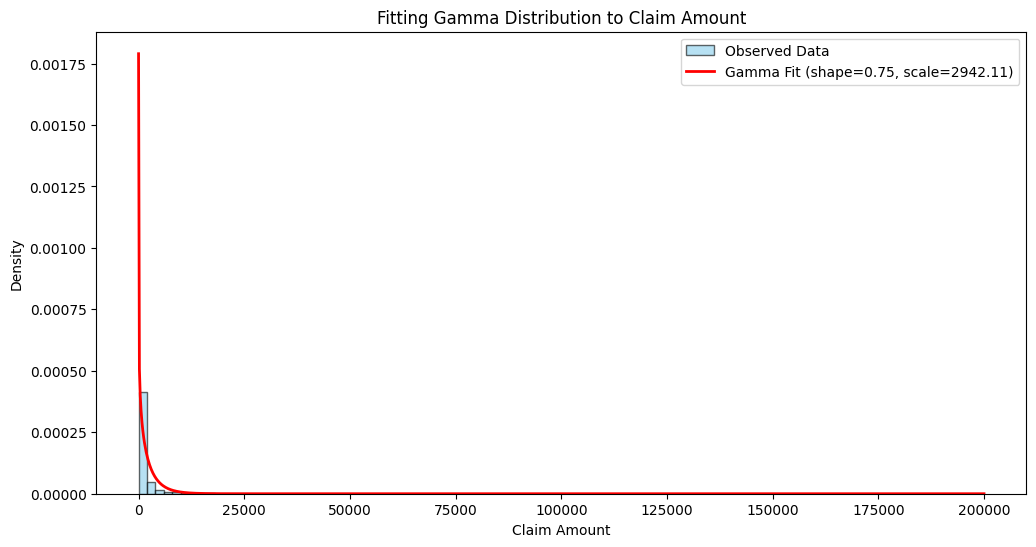

In [117]:
# Fit Gamma distribution to the claim amount
positive_claims = train_data['ClaimAmount'][train_data['ClaimAmount'] > 0]

shape, loc, scale = gamma.fit(positive_claims, floc=0)  

gamma_dist = gamma(a=shape, loc=loc, scale=scale)

plt.figure(figsize=(12, 6))
plt.hist(positive_claims, bins=100, color='skyblue', edgecolor='black', density=True, alpha=0.6, label="Observed Data")
x = np.linspace(positive_claims.min(), positive_claims.max(), 1000)
plt.plot(x, gamma_dist.pdf(x), 'r-', lw=2, label=f'Gamma Fit (shape={shape:.2f}, scale={scale:.2f})')
plt.xlabel('Claim Amount')
plt.ylabel('Density')
plt.title('Fitting Gamma Distribution to Claim Amount')
plt.legend()
plt.show()

In [118]:
log_likelihood = lognorm_dist.logpdf(positive_claims).sum()
print('Lognormal log-likelihood:', log_likelihood)

Lognormal log-likelihood: -21735.515083789913


In [119]:
log_likelihood = gamma_dist.logpdf(positive_claims).sum()
print('Gamma log-likelihood:', log_likelihood)

Gamma log-likelihood: -22221.881266171382


Gamma has a lower log-likelihood, meaning it has better goodness of fit to the training data than the LogNormal distribution for severity.

In [120]:
#Simulate ClaimAmount on validation set using both distributions

lognorm_forecasts = lognorm_dist.rvs(size=len(valid_data))

gamma_forecasts = gamma_dist.rvs(size=len(valid_data))

actual_claims = valid_data['ClaimAmount'].values

mse_lognorm = mean_squared_error(actual_claims, lognorm_forecasts)
mse_gamma = mean_squared_error(actual_claims, gamma_forecasts)

print('Lognormal MSE:', mse_lognorm)
print('Gamma MSE:', mse_gamma)



Lognormal MSE: 18253386.19253794
Gamma MSE: 13035690.158067493


Gamma has a lower mean-squared error on the validation set, meaning it has better forecasting performance than LogNormal for claim severity. 

We therefore select Gamma as the distribution that has the best goodness-of fit and forecasting performance for claim severity.

### LOSS PREDICTION FOR NEXT YEAR

In [121]:
# Monte Carlo simulation to model next year losses using Poisson and Gamma distributions
n_simulations = 100000  # Number of paths

total_losses_nextyear = np.zeros(n_simulations)

for i in range(n_simulations):
    n_claims = poisson.rvs(mu=lambda_poisson)
    
    if n_claims > 0:
        claim_amounts = gamma.rvs(a=shape, scale=scale, size=n_claims)
        total_losses_nextyear[i] = np.sum(claim_amounts)
    else:
        total_losses_nextyear[i] = 0


mean_loss = np.mean(total_losses_nextyear)
median_loss = np.median(total_losses_nextyear)
percentile_95 = np.percentile(total_losses_nextyear, 95)
percentile_99 = np.percentile(total_losses_nextyear, 99)


print(f"Mean Total Loss: {mean_loss:.2f}")
print(f"Median Total Loss: {median_loss:.2f}")
print(f"95th Percentile of Total Loss: {percentile_95:.2f}")
print(f"99th Percentile of Total Loss: {percentile_99:.2f}")


Mean Total Loss: 86.04
Median Total Loss: 0.00
95th Percentile of Total Loss: 0.00
99th Percentile of Total Loss: 2952.37


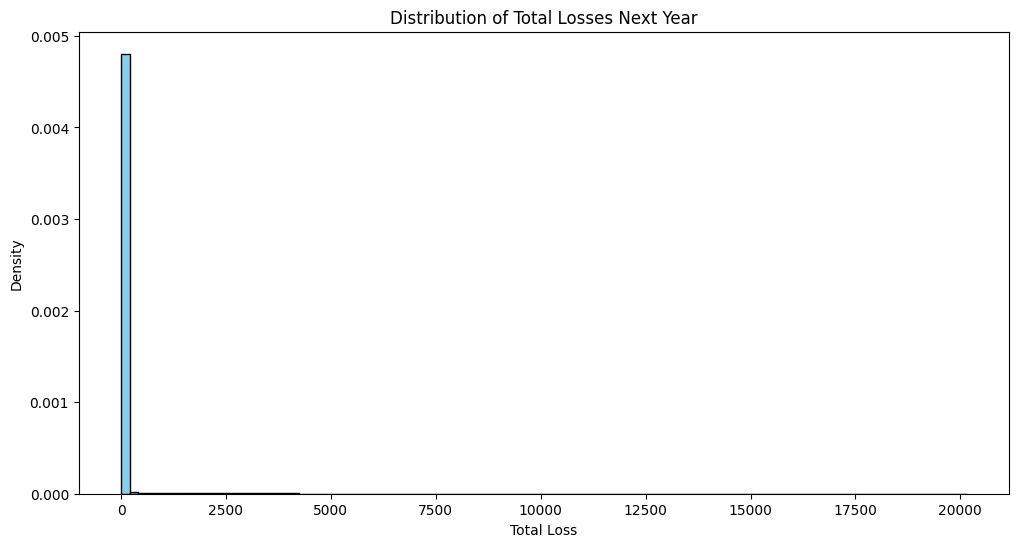

In [122]:
# plot the distribution of total losses
plt.figure(figsize=(12, 6))
plt.hist(total_losses_nextyear, bins=100, color='skyblue', edgecolor='black', density=True)
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Distribution of Total Losses Next Year')
plt.show()


We have now simulated total losses for next year, allowing us to set premiums accordingly. 

### PREMIUM DETERMINATION